In [1]:
import os
import keyring
# import warnings
# warnings.filterwarnings('ignore')
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [2]:
# web search and code execution tool
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

In [3]:
# recent stock prices and financial analyzing tool with yfinance
import yfinance as yf 
from datetime import datetime, timedelta
import pandas as pd 

ticker = yf.Ticker('NVDA')
historical_prices = ticker.history(period='5d', interval='1d')

last_5_days_close = historical_prices['Close'].tail(5)
last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}

# annual and quarterly financial statements data
last_5_days_close_dict

{'2024-11-22': 141.9499969482422,
 '2024-11-25': 136.02000427246094,
 '2024-11-26': 136.9199981689453,
 '2024-11-27': 135.33999633789062,
 '2024-11-29': 138.25}

In [4]:
from langchain.tools import BaseTool, StructuredTool, tool
import yfinance as yf 
from datetime import datetime, timedelta
import pandas as pd 

# financial analysis tool
@tool
def stock_analysis(ticker: str) -> str:
    """ 
    Total financial analysis on the figen stock ticker.
    Recent stock prices, financial statements, growth rates, valuation and ratios.
    Args
        ticker: str - stock ticker
        return: str -
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return 'N/A'
        return f"{number:,.0f}"
    
    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                'Total revenue': format_number(data.get('TotalRevenue')),
                'Operating Income': format_number(data.get('OperatingIncome')),
                'Net Income': format_number(data.get('NetIncome')),
                'EBITDA': format_number(data.get('EBITDA')),
                'Diluted EPS': f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary
    
    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period='5d', intervals='1d')
    
    last_5_days_close = historical_prices['Close'].tail(5)
    last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
    
    # annual and quarterly financial statements
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq='quarterly')
    
    return str({
        "Recent 5 days close prices": last_5_days_close_dict,
        "annual financial statements summary": format_financial_summary(annual_financials),
        "quarterly financial statements summary": format_financial_summary(quarterly_financials),
    })

In [6]:
# Supervisor agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ['Researcher', 'Stock_Analyzer', 'Chart_Generator']
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# our team supervisor is an LLM node. It just picks the next agent to process
# and decided when the work is completed
options = ['FINISH'] + members

class routeResponse(BaseModel):
    next: Literal['FINISH', 'Researcher', 'Stock_Analyzer', 'Chart_Generator']
    
prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        )
    ]
).partial(options=", ".join(options), members=", ".join(members))
     
llm = ChatOpenAI(model='gpt-4o-mini')

def supervisor_agent(state):
    supervisor_chain = (
        prompt | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [7]:
# define sub agent function
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [8]:
# setting sub agent
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# the agent state is the input to each node in the graph
class AgentState(TypedDict):
    # the annotation tells the graph that new messages will always 
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # the 'next' field indicates where to route to next
    next: str
    
research_system_prompt = """You are a helpful research analyst who is specialized in
gathering valuable info for given stock."""
research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt = """You are a helpful Stock and financial analyst. Never hallucinate the given mectrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt = """You are a helpful Stock Chart Generator.
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name='Chart_Generator')

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("Supervisor", supervisor_agent)

In [9]:
for member in members:
    # we want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, 'Supervisor')

# The Supervisor populates the 'next' field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    conditional_map
)

# finally, and entrypoint
workflow.add_edge(START, "Supervisor")

graph = workflow.compile()

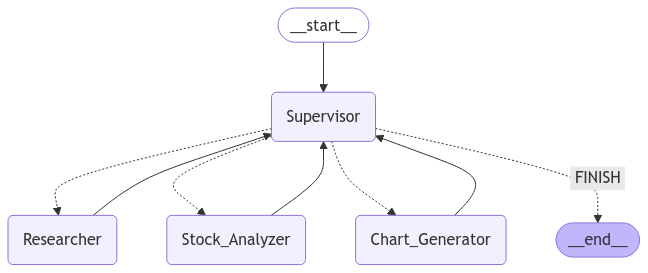

In [10]:
# plot the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

{'Supervisor': {'next': 'Researcher'}}
-----
{'Researcher': {'messages': [HumanMessage(content='애플(AAPL) 주식에 대한 구매 결정을 내리기 위해 다음과 같은 정보를 고려할 수 있습니다:\n\n1. **애널리스트 평점 및 목표주가**:\n   - 애널리스트 32명이 제공한 12개월 목표주가의 평균은 **$239.78**이며, 최소 예상가는 **$180**, 최대 예상가는 **$300**입니다. (출처: [Stock Analysis](https://stockanalysis.com/stocks/aapl/forecast/))\n   - 애플 주식에 대한 평균 애널리스트 평가는 **"매수"**입니다.\n\n2. **현재 주가 및 역사적 데이터**:\n   - 현재 애플 주가는 약 **$189.99**입니다. (출처: [Zacks](https://www.zacks.com/stock/research/AAPL/price-target-stock-forecast))\n   - 최근 52주 최고가는 **$237.49**, 최저가는 **$164.07**입니다. (출처: [MacroTrends](https://www.macrotrends.net/stocks/charts/AAPL/apple/stock-price-history))\n\n3. **시장 분석 및 전망**:\n   - 애플은 최근 몇 달 동안 내부자들이 주식을 더 많이 판매했으며, 이는 잠재적으로 투자자에게 경고 신호가 될 수 있습니다. (출처: [MarketBeat](https://www.marketbeat.com/stocks/NASDAQ/AAPL/))\n   - 전반적으로 애플은 **"중간 매수"** 또는 **"강력 매수"** 등급을 받고 있으며, 이는 긍정적인 투자 신호로 해석될 수 있습니다. (출처: [Yahoo Finance](https://finance.yahoo.com/quote/AAPL/analysis/))\n\n4. **재무 건전

Python REPL can execute arbitrary code. Use with caution.


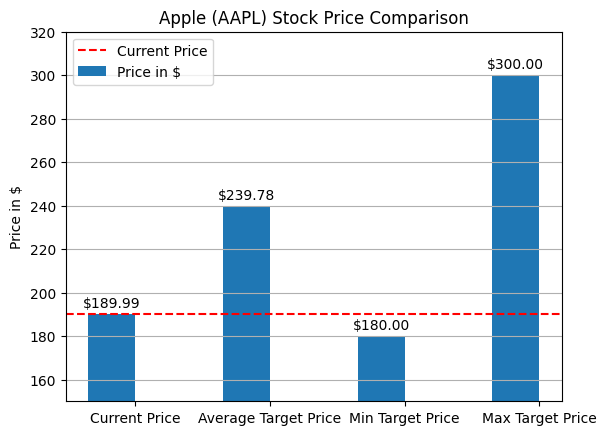

{'Chart_Generator': {'messages': [HumanMessage(content="Here is the stock price analysis chart for Apple (AAPL):\n\n- The chart compares the current price of Apple stock with the average, minimum, and maximum target prices set by analysts.\n- The dashed red line indicates the current stock price of $189.99.\n\nThis visual representation helps in understanding how the current price stands in relation to the analysts' expectations.", additional_kwargs={}, response_metadata={}, name='Chart_Generator')]}}
-----
{'Supervisor': {'next': 'FINISH'}}
-----


In [11]:
for s in graph.stream({"messages": [HumanMessage(content="애플 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("-----")